# ICAL pipeline processing using arlexecute workflows.

This notebook demonstrates the ICAL pipeline. 

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from wrappers.serial.calibration.calibration import solve_gaintable
from wrappers.serial.calibration.operations import apply_gaintable
from wrappers.serial.calibration.calibration_control import create_calibration_controls
from wrappers.serial.visibility.base import create_blockvisibility
from wrappers.serial.skycomponent.operations import create_skycomponent
from wrappers.serial.image.deconvolution import deconvolve_cube
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image
from wrappers.serial.visibility.iterators import vis_timeslice_iter
from wrappers.serial.simulation.testing_support import create_named_configuration, create_low_test_image_from_gleam
from wrappers.serial.imaging.base import predict_2d, create_image_from_visibility, advise_wide_field

from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow, \
    predict_list_arlexecute_workflow, deconvolve_list_arlexecute_workflow
from workflows.arlexecute.simulation.simulation_arlexecute import simulate_list_arlexecute_workflow, \
    corrupt_list_arlexecute_workflow
from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client

In [2]:
import logging

def init_logging():
    log = logging.getLogger()
    logging.basicConfig(filename='%s/imaging-pipeline.log' % results_dir,
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.INFO)
log = logging.getLogger()
logging.info("Starting imaging-pipeline")

We will use dask

In [3]:
client = get_dask_Client(memory_limit=4* 1024 * 1024 * 1024, n_workers=7)
arlexecute.set_client(client)
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:52107': None,
 'tcp://127.0.0.1:52108': None,
 'tcp://127.0.0.1:52111': None,
 'tcp://127.0.0.1:52115': None,
 'tcp://127.0.0.1:52118': None,
 'tcp://127.0.0.1:52119': None,
 'tcp://127.0.0.1:52125': None}

In [4]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [5]:
nfreqwin=7
ntimes=5
rmax=750.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

vis_list=simulate_list_arlexecute_workflow('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax)
print('%d elements in vis_list' % len(vis_list))
log.info('About to make visibility')
vis_list = arlexecute.compute(vis_list, sync=True)

7 elements in vis_list
arlexecute.compute: Execution using Dask took 2.461 seconds


In [6]:
import pprint

pp = pprint.PrettyPrinter()

advice=advise_wide_field(vis_list[-1], guard_band_image=8.0, delA=0.05)
pp.pprint(advice)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

{'cellsize': 0.0006964749202664379,
 'delA': 0.05,
 'diameter': 35.0,
 'facet_fov': 0.5710332533333333,
 'facets': 1,
 'freq_sampling_image': 24636.864709420577,
 'freq_sampling_primary_beam': 1576759.341402917,
 'guard_band_image': 8.0,
 'image_fov': 0.5710332533333333,
 'max_wavelength': 2.498270483333333,
 'maximum_baseline': 478.60062671864193,
 'min_wavelength': 2.498270483333333,
 'npixels': 820,
 'npixels2': 1024,
 'nwpixels': 116,
 'oversampling_synthesised_beam': 3.0,
 'primary_beam_fov': 0.07137915666666667,
 'synthesized_beam': 0.0020894247607993136,
 'time_sampling_image': 17.738542590782814,
 'time_sampling_primary_beam': 1135.2667258101,
 'vis_slices': 48,
 'w_sampling_facet': 0.30869338868892066,
 'w_sampling_image': 0.30869338868892066,
 'w_sampling_primary_beam': 19.756376876090922,
 'wprojection_planes': 48,
 'wstep': 19.756376876090922}


Now make a graph to fill with a model drawn from GLEAM 

In [9]:
gleam_model = [arlexecute.execute(create_low_test_image_from_gleam)(npixel=npixel,
                                                                    frequency=[frequency[f]],
                                                                    channel_bandwidth=[channel_bandwidth[f]],
                                                                    cellsize=cellsize,
                                                                    phasecentre=phasecentre,
                                                                    polarisation_frame=PolarisationFrame("stokesI"),
                                                                    flux_limit=0.3,
                                                                    applybeam=True,
                                                                    kind='cubic')
                     for f, freq in enumerate(frequency)]
log.info('About to make GLEAM model')
gleam_model = arlexecute.compute(gleam_model, sync=True)
future_gleam_model = arlexecute.scatter(gleam_model)

arlexecute.compute: Execution using Dask took 59.033 seconds


Now predict the visibility from this model, and then apply some phase errors

In [10]:
future_vis_graph = arlexecute.scatter(vis_list)
predicted_vislist = predict_list_arlexecute_workflow(future_vis_graph, future_gleam_model,  
                                                context='wstack', vis_slices=vis_slices)
predicted_vislist = arlexecute.compute(predicted_vislist, sync=True)
corrupted_vislist = corrupt_list_arlexecute_workflow(predicted_vislist, phase_error=1.0, seed=180555)
corrupted_vislist =  arlexecute.compute(corrupted_vislist, sync=True)
future_corrupted_vislist = arlexecute.scatter(corrupted_vislist)

arlexecute.compute: Execution using Dask took 54.531 seconds
arlexecute.compute: Execution using Dask took 3.447 seconds


Get the LSM. This is currently blank. Style of ARL is to create e.g. template images and pass those

In [11]:
model_list = [arlexecute.execute(create_image_from_visibility)(vis_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

Create and execute graph to make the dirty image

In [12]:
log.info('About to run invert to get dirty image')
dirty_list = invert_list_arlexecute_workflow(future_corrupted_vislist, model_list,
                                                 context='wstack',
                                                 vis_slices=vis_slices, dopsf=False)

dirty_list = arlexecute.compute(dirty_list, sync=True)

arlexecute.compute: Execution using Dask took 48.027 seconds


Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '2.742107625318667'
		min: '-0.19274736231326486'
		rms: '0.04217683027379378'
		sum: '111.90412743039951'
		medianabs: '0.022592159895334543'
		median: '-0.0007824149098030729'



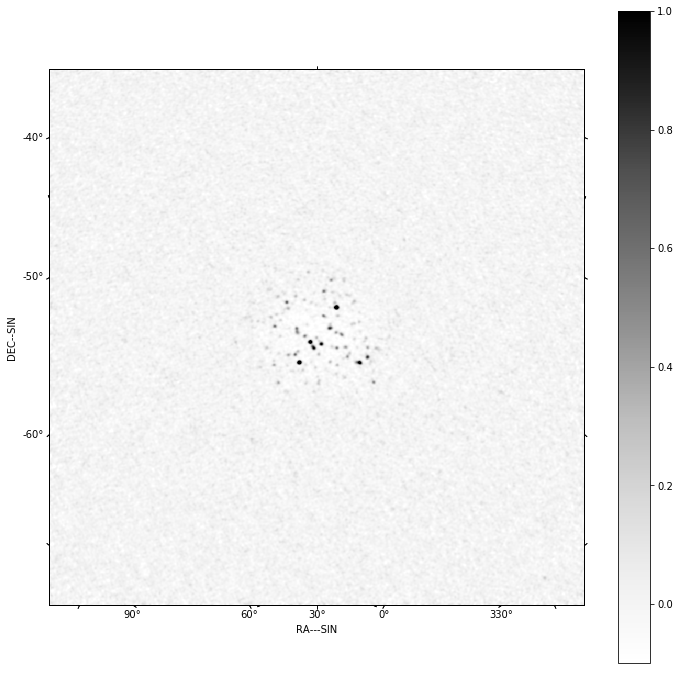

In [13]:
dirty = dirty_list[0][0]
show_image(dirty, cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(dirty))
plt.show()

Now we set up the ICAL pipeline calibration controls

In [14]:

controls = create_calibration_controls()
        
controls['T']['first_selfcal'] = 1
controls['G']['first_selfcal'] = 3
controls['B']['first_selfcal'] = 4

controls['T']['timescale'] = 'auto'
controls['G']['timescale'] = 'auto'
controls['B']['timescale'] = 1e5

pp.pprint(controls)

{'B': {'first_selfcal': 4,
       'phase_only': False,
       'shape': 'vector',
       'timescale': 100000.0,
       'timeslice': 100000.0},
 'G': {'first_selfcal': 3,
       'phase_only': False,
       'shape': 'vector',
       'timescale': 'auto',
       'timeslice': 60.0},
 'I': {'first_selfcal': 0,
       'phase_only': True,
       'shape': 'vector',
       'timeslice': 1.0},
 'P': {'first_selfcal': 0,
       'phase_only': False,
       'shape': 'matrix',
       'timeslice': 10000.0},
 'T': {'first_selfcal': 1,
       'phase_only': True,
       'shape': 'scalar',
       'timescale': 'auto',
       'timeslice': 'auto'}}


Run ICAL with:
 - wstacking
 - msmfs distributed clean (8 by 8 subimages overlapped by 16 pixels)
 - selfcal for T (first iteration), G (third iteration), B (fourth iteration)

In [15]:
future_corrupted_vislist = arlexecute.scatter(corrupted_vislist)
ical_list = ical_list_arlexecute_workflow(future_corrupted_vislist, 
                                          model_imagelist=model_list,  
                                          context='wstack', 
                                          vis_slices=vis_slices,
                                          scales=[0, 3, 10], algorithm='mmclean', 
                                          nmoment=3, niter=1000, 
                                          fractional_threshold=0.1,
                                          threshold=0.01, nmajor=5, gain=0.25,
                                          psf_support=64,
                                          deconvolve_facets = 8, 
                                          deconvolve_overlap=16,
                                          deconvolve_taper='tukey',
                                          timeslice='auto',
                                          global_solution=False, 
                                          do_selfcal=True,
                                          calibration_context = 'TG', 
                                          controls=controls)

In [16]:
log.info('About to run ical')
result=arlexecute.compute(ical_list, sync=True)
deconvolved = result[0][0]
residual = result[1][0]
restored = result[2][0]

f=show_image(deconvolved, title='Clean image', cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f=show_image(restored, title='Restored clean image', cm='Greys', vmax=1.0, 
             vmin=-0.1)
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_ical_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(residual[0], context='Residual clean image'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_ical_residual.fits' 
                     %(results_dir))

distributed.nanny - WARNING - Worker process 29644 was killed by unknown signal


KeyboardInterrupt: 

distributed.nanny - WARNING - Worker process 29641 was killed by unknown signal
distributed.nanny - WARNING - Worker process 29645 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - ERROR - Failed to restart worker after its process exited
Traceback (most recent call last):
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/nanny.py", line 291, in _on_exit
    yield self.instantiate()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1107

distributed.nanny - ERROR - Failed to restart worker after its process exited
Traceback (most recent call last):
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/nanny.py", line 291, in _on_exit
    yield self.instantiate()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/nanny.py", line 226, in instantiate
    self.process.start()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "

In [ ]:
arlexecute.close()